In [1]:
%matplotlib inline
import sys
sys.path.append("..")

In [2]:
import random

import deeptrack as dt

import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf

tracker_input_size = 64


In [3]:
class CrescentMoon(dt.Ellipse):
    def get(self, *inp, radius, offset, **kwargs):
        ellipse = super().get(*inp, radius=radius, **kwargs)
        offset = np.round(offset).astype(np.int)
        other = dt.Affine(translate=offset, mode="constant").resolve(ellipse)
        ellipse[np.array(other > 0)] = 0
        
        return ellipse
        
class Rectangle(dt.Scatterer):
    def get(self, *inp, width, height, **kwargs):
        return np.ones((round(width), round(height), 1))
        

In [4]:

commons = dt.DummyFeature(
    image_size=tracker_input_size,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

arguments = dt.Arguments(
    noise_level=10,
    particle_type="moon"
)

fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, tracker_input_size, tracker_input_size)
)

poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand()*7 + 20,
    background=0.1
)


moon_particle = CrescentMoon(radius=1e-6, offset=(5, 0), position=commons.position)
rectangle_particle = Rectangle(height=18, width=12, position=commons.position)

particle = dt.ConditionalSetFeature(
    on_false=rectangle_particle,
    on_true=moon_particle,
    condition=lambda particle_type: particle_type == "moon",
    particle_type=arguments.particle_type
)

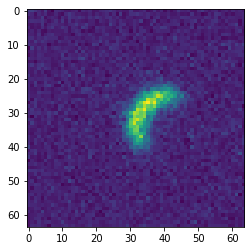

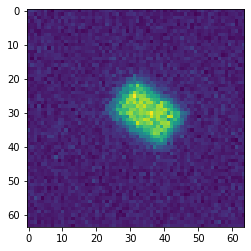

In [5]:


pipeline = (
    fluorescence_microscope(particle)
    >> dt.Affine(rotate=lambda:np.random.rand() * 2 * np.pi)
    >> dt.NormalizeMinMax() 
    + 0.2
) >> dt.Poisson(snr=arguments.noise_level, background=0.2) >> dt.NormalizeMinMax()

pipeline.bind_arguments(arguments)

pipeline.plot()
dt.Bind(pipeline, particle_type="rect").plot()

In [6]:
moon_dataset = [pipeline.update().resolve(particle_type="moon") for _ in range(500)]
moon_dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) for d in moon_dataset]

rect_dataset = [pipeline.update().resolve(particle_type="rect") for _ in range(500)]
rect_dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) for d in rect_dataset]

In [19]:
import tensorflow as tf

def orientation_error(symmetries=1):
    def error_func(T, P):
        angle = tf.math.atan2(P[:, 1], P[:, 0]) / symmetries
        true_angle = T % (np.pi * 2 / symmetries)

        diff = (angle - true_angle)

        diff = (diff - tf.keras.backend.mean(diff) + np.pi / symmetries) % (2 * np.pi / symmetries)
        diff = diff - tf.keras.backend.mean(diff)

        return tf.keras.backend.mean(tf.keras.backend.abs(diff))

    return error_func

class ValidationOnlyMetric(tf.keras.metrics.Metric):

    def __init__(self, metric, **kwargs):
        # Initialise as normal and add flag variable for when to run computation
        super(ValidationOnlyMetric, self).__init__(**kwargs)
        self.metric_variable = self.add_weight(name='metric_variable', initializer='zeros')
        self.update_metric = tf.Variable(False)
        self.metric = metric

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Use conditional to determine if computation is done
        if self.update_metric:
            computation_result = self.metric(y_true, y_pred)
            self.metric_variable.assign_add(computation_result)

    def result(self):
        return self.metric_variable

    def reset_states(self):
        self.metric_variable.assign(0.)

class RunValidationMetrics(tf.keras.callbacks.Callback):
    '''On test begin (i.e. when evaluate() is called or 
     validation data is run during fit()) toggle metric flag '''
    def on_test_begin(self, logs):
        for metric in self.model.metrics:
            print(metric.name)
            if 'ValidationOnlyMetric' in metric.name:
                metric.on.assign(True)
    def on_test_end(self,  logs):
        for metric in self.model.metrics:
            print(metric.name)
            if 'ValidationOnlyMetric' in metric.name:
                metric.on.assign(False)

In [21]:


moon_model = dt.models.AutoTracker(
    input_shape=(tracker_input_size, tracker_input_size, 1),
    mode="orientation",
    symmetries=1,
    validation_data=(
        np.array(moon_dataset),
        np.array(moon_dataset_labels),
    )
)
moon_model.compile(metrics=[ValidationOnlyMetric(orientation_error(1))])

rect_model = dt.models.AutoTracker(
    input_shape=(tracker_input_size, tracker_input_size, 1),
    mode="orientation",
    symmetries=2,
    metrics=[ValidationOnlyMetric(orientation_error(2))],
    validation_data=(
        np.array(rect_dataset),
        np.array(rect_dataset_labels),
    )
)


moon_model.fit(dt.Value(lambda: random.choice(moon_dataset[:1])), batch_size=8, epochs=30, callbacks=[ToggleMetrics()])
rect_model.fit(dt.Value(rect_dataset[0]), batch_size=8, epochs=60, callbacks=[ToggleMetrics()])

Generating 800 / 400 samples before starting training
Epoch 1/30


ValueError: in user code:

    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:498 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:598 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    C:\Users\GU\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\utils.py:78 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv2d_36/kernel:0', 'conv2d_36/bias:0', 'conv2d_37/kernel:0', 'conv2d_37/bias:0', 'conv2d_38/kernel:0', 'conv2d_38/bias:0', 'dense_36/kernel:0', 'dense_36/bias:0', 'dense_37/kernel:0', 'dense_37/bias:0', 'dense_38/kernel:0', 'dense_38/bias:0'].


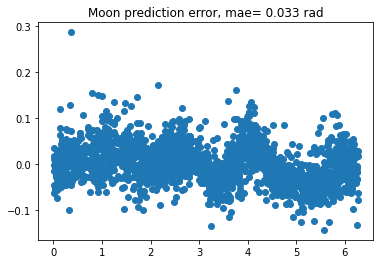

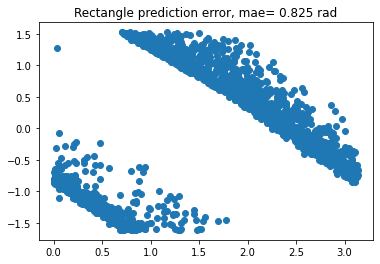

In [31]:

for (
    model,
    dataset,
    symmetries,
    name
) in zip(
    [moon_model, rect_model],
    [moon_dataset[1:], rect_dataset[1:]],
    [1, 2],
    ["Moon", "Rectangle"]
):

    predicted_angle = model.predict(np.array(dataset))
    predicted_angle_2 = model.predict(np.array(dataset)[:, ::-1])

    angle = np.arctan2(predicted_angle[:, 1], predicted_angle[:, 0]) / symmetries
    angle_2 = np.arctan2(predicted_angle_2[:, 1], predicted_angle_2[:, 0]) / symmetries


    dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) % ( 2 * np.pi / symmetries ) for d in dataset]

    diff = (angle - dataset_labels)

    diff = (diff - np.mean(diff) + np.pi / symmetries) % (np.pi)
    diff = diff - np.mean(diff)


    plt.scatter(dataset_labels, diff)
    plt.title(f"{name} prediction error, mae={np.mean(np.abs(diff)): .3f} rad")
    plt.show()



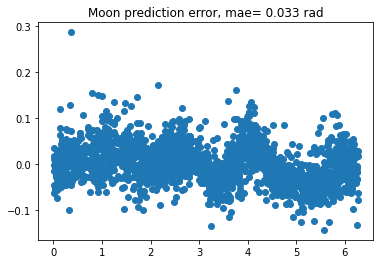

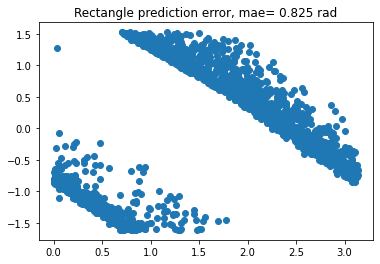

In [30]:

for (
    model,
    dataset,
    symmetries,
    name
) in zip(
    [moon_model, rect_model],
    [moon_dataset[1:], rect_dataset[1:]],
    [1, 2],
    ["Moon", "Rectangle"]
):

    predicted_angle = model.predict(np.array(dataset))
    predicted_angle_2 = model.predict(np.array(dataset)[:, ::-1])

    angle = np.arctan2(predicted_angle[:, 1], predicted_angle[:, 0]) / symmetries
    angle_2 = np.arctan2(predicted_angle_2[:, 1], predicted_angle_2[:, 0]) / symmetries


    dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) % ( 2 * np.pi / symmetries ) for d in dataset]

    diff = (angle - dataset_labels)

    diff = (diff - np.mean(diff) + np.pi / symmetries) % (np.pi)
    diff = diff - np.mean(diff)


    plt.scatter(dataset_labels, diff)
    plt.title(f"{name} prediction error, mae={np.mean(np.abs(diff)): .3f} rad")
    plt.show()



In [11]:
for _x, y in zip(x, dataset):
    
    ang = np.arctan2(_x[3], _x[2]) / 2
    _x = np.cos(ang)
    _y = np.sin(ang)
    
    plt.imshow(y)
    plt.quiver([32], [32], [_x], [_y], color="w", scale=4)
    plt.show()
    

NameError: name 'x' is not defined

In [ ]:
for _x, y in zip(x, dataset):
    
    ang = np.arctan2(_x[3], _x[2]) / 2
    _x = np.cos(ang)
    _y = np.sin(ang)
    
    plt.imshow(y)
    plt.quiver([32], [32], [_x], [_y], color="w")
    plt.show()
    